In [1]:
import numpy as np
import scipy as sc
import scipy.optimize
from warnings import warn
import sparse_ir
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# If true, we use sampling points in [0, beta].
# If false, we use sampling points in [-beta/2, beta/2].
# sparse-ir version 1 defaults to use_positive_taus=True, 
# but sparse-ir version 2 defaults to use_positive_taus=False.
use_positive_taus = False

In [3]:
### System parameters
t    = 1      # hopping amplitude
W    = 8*t    # bandwidth
wmax = 10     # set wmax >= W

T    = 0.1    # temperature
beta = 1/T    # inverse temperature
n    = 0.85   # electron filling, here per spin per lattice site (n=1: half filling)
U    = 4      # Hubbard interaction

### Numerical parameters
nk1, nk2  = 24, 24    # number of k_points along one repiprocal crystal lattice direction k1 = kx, k2 = ky
nk        = nk1*nk2
IR_tol    = 1e-10     # desired accuary for l-cutoff of IR basis functions
sfc_tol   = 1e-4      # desired accuracy for self-consistent iteration
maxiter   = 30        # maximal number of iterations in self-consistent cycle
mix       = 0.2       # mixing parameter for new green function
U_maxiter = 50        # maximal number of iteration steps in U renormalization loop

In [4]:
#### Initiate fermionic and bosonic IR basis objects
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol, use_positive_taus=use_positive_taus)

class Mesh:
    """
    Holding class for k-mesh and sparsely sampled imaginary time 'tau' / Matsubara frequency 'iwn' grids.
    Additionally it defines the Fourier transform routines 'r <-> k'  and 'tau <-> l <-> wn'.
    """
    def __init__(self,IR_basis_set,nk1,nk2):
        self.IR_basis_set = IR_basis_set

        # generate k-mesh and dispersion
        self.nk1, self.nk2, self.nk = nk1, nk2, nk1*nk2
        self.k1, self.k2 = np.meshgrid(np.arange(self.nk1)/self.nk1, np.arange(self.nk2)/self.nk2)
        self.ek = -2*t*( np.cos(2*np.pi*self.k1) + np.cos(2*np.pi*self.k2) ).reshape(nk)

        # lowest Matsubara frequency index
        self.iw0_f = np.where(self.IR_basis_set.wn_f == 1)[0][0]
        self.iw0_b = np.where(self.IR_basis_set.wn_b == 0)[0][0]

        ### Generate a frequency-momentum grid for iwn and ek (in preparation for calculating the Green function)
        # frequency mesh (for Green function)
        self.iwn_f = 1j * self.IR_basis_set.wn_f * np.pi * T
        self.iwn_f_ = np.tensordot(self.iwn_f, np.ones(nk), axes=0)

        # ek mesh
        self.ek_ = np.tensordot(np.ones(len(self.iwn_f)), self.ek, axes=0)

    def smpl_obj(self, statistics):
        """ Return sampling object for given statistic """
        smpl_tau = {'F': self.IR_basis_set.smpl_tau_f, 'B': self.IR_basis_set.smpl_tau_b}[statistics]
        smpl_wn  = {'F': self.IR_basis_set.smpl_wn_f,  'B': self.IR_basis_set.smpl_wn_b }[statistics]
        return smpl_tau, smpl_wn

    
    def tau_to_wn(self, statistics, obj_tau):
        """ Fourier transform from tau to in via IR basis """
        smpl_tau, smpl_wn = self.smpl_obj(statistics)

        obj_tau = obj_tau.reshape((smpl_tau.tau.size, self.nk1, self.nk2))
        obj_l   = smpl_tau.fit(obj_tau, axis=0)
        obj_wn  = smpl_wn.evaluate(obj_l, axis=0).reshape((smpl_wn.wn.size, self.nk))
        return obj_wn

    def wn_to_tau(self, statistics, obj_wn):
        """ Fourier transform from iwn to tau via IR basis """
        smpl_tau, smpl_wn = self.smpl_obj(statistics)

        obj_wn  = obj_wn.reshape((smpl_wn.wn.size, self.nk1, self.nk2))
        obj_l   = smpl_wn.fit(obj_wn, axis=0)
        obj_tau = smpl_tau.evaluate(obj_l, axis=0).reshape((smpl_tau.tau.size, self.nk))
        return obj_tau

    
    def k_to_r(self,obj_k):
        """ Fourier transform from k-space to real space """
        obj_k = obj_k.reshape(-1, self.nk1, self.nk2)
        obj_r = np.fft.fftn(obj_k,axes=(1,2))
        obj_r = obj_r.reshape(-1, self.nk)
        return obj_r

    def r_to_k(self,obj_r):
        """ Fourier transform from real space to k-space """
        obj_r = obj_r.reshape(-1, self.nk1, self.nk2)
        obj_k = np.fft.ifftn(obj_r,axes=(1,2))/self.nk
        obj_k = obj_k.reshape(-1, self.nk)
        return obj_k

In [5]:
class FLEXSolver:
    def __init__(self, mesh, U, n, sigma_init=0, sfc_tol=1e-4, 
                 maxiter=100, U_maxiter=10, mix=0.2, verbose=True):
        """
        Solver class to calculate the FLEX loop self-consistently.
        After initializing the Solver by `solver = FLEXSolver(mesh, U, n, **kwargs)` 
        it can be run by `solver.solve()`.
        """
        ## Set internal parameters for the solve 
        self.U = U
        self.n = n
        self.mesh = mesh
        self.sigma = sigma_init
        self.sfc_tol = sfc_tol
        self.maxiter = maxiter
        self.U_maxiter = U_maxiter
        self.mix = mix
        self.verbose = verbose
        
        ## Set initial Green function and irreducible susceptibility
        # NOT running the FLEXSolver.solve instance corresponds to staying on RPA level
        self.mu = 0
        self.mu_calc()
        
        self.gkio_calc(self.mu)
        self.grit_calc()
        self.ckio_calc()
    
    
    #%%%%%%%%%%% Loop solving instance
    def solve(self):
        """ FLEXSolver.solve() executes FLEX loop until convergence """
        # check whether U < U_crit! Otherwise, U needs to be renormalized.
        if np.amax(np.abs(self.ckio))*self.U >= 1:
            self.U_renormalization()
            
        # perform loop until convergence is reached:
        for it in range(self.maxiter):
            sigma_old = self.sigma
            self.loop()

            # check whether solution is converged.
            sfc_check = np.sum(abs(self.sigma-sigma_old))/np.sum(abs(self.sigma))
            if self.verbose:
                print(it, sfc_check)
            if sfc_check < self.sfc_tol:
                print("FLEX loop converged at desired accuracy")
                break
        print("FLEX loop finished", " mu = ", self.mu, "n = ",  self.calc_electron_density(self.mu))
    
    def loop(self):
        """ FLEX loop """
        gkio_old = self.gkio
        
        # calculate interaction and self-energy
        self.V_calc()
        self.sigma_calc()
        
        # set new chemical potential and apply mixing
        self.mu_calc()
        self.gkio_calc(self.mu)
        self.gkio = self.mix*self.gkio + (1-self.mix)*gkio_old
        
        # calculate new irreducible susceptibility
        self.grit_calc()
        self.ckio_calc()


    #%%%%%%%%%%% U renormalization loop instance
    def U_renormalization(self):
        """ Loop for renormalizing U if Stoner enhancement U*max{chi0} >= 1. """
        print('WARNING: U is too large and the spin susceptibility denominator will diverge/turn unphysical!')
        print('Initiate U renormalization loop.')
    
        # save old U for later
        U_old = self.U
        # renormalization loop may run infinitely! Insert break condition after U_it_max steps
        U_it = 0
    
        while U_old*np.amax(np.abs(self.ckio)) >= 1:
            U_it += 1
        
            # remormalize U such that U*chi0 < 1
            self.U = self.U / (np.amax(np.abs(self.ckio))*self.U + 0.01)
            print(U_it, self.U, U_old)
        
            # perform one shot FLEX loop
            self.loop()
        
            # reset U
            self.U = U_old
        
            # break condition for too many steps
            if U_it == self.U_maxiter:
                print('Iteration number of U renormalization reached break condition!')
                break
        print('Leaving U renormalization...')
    
    
    #%%%%%%%%%%% Calculation steps
    def gkio_calc(self, mu):
        """ calculate Green function G(iw,k) """
        self.gkio = (self.mesh.iwn_f_ - (self.mesh.ek_ - mu) - self.sigma)**(-1)

    def grit_calc(self):
        """ Calculate real space Green function G(tau,r) [for calculating chi0 and sigma] """
        # Fourier transform
        grit = self.mesh.k_to_r(self.gkio)
        self.grit = self.mesh.wn_to_tau('F', grit)

    def ckio_calc(self):
        """ Calculate irreducible susciptibility chi0(iv,q) """
        if use_positive_taus:
            # G(tau) * G(beta - tau)
            ckio = self.grit * self.grit[::-1, :]
        else:
            # - G(tau) * G(- tau)
            ckio = - self.grit * self.grit[::-1, :]

        # Fourier transform
        ckio = self.mesh.r_to_k(ckio)
        self.ckio = self.mesh.tau_to_wn('B', ckio)

    def V_calc(self):
        """ Calculate interaction V(tau,r) from RPA-like spin and charge susceptibility for calculating sigma """
        # check whether U is too large and give warning
        if np.amax(np.abs(self.ckio))*self.U >= 1:
            warn("U*max(chi0) >= 1! Paramagnetic phase is left and calculations will turn unstable!")
        
        # spin and charge susceptibility
        self.chi_spin   = self.ckio / (1 - self.U*self.ckio)
        self.chi_charge = self.ckio / (1 + self.U*self.ckio)

        V = 3/2*self.U**2 * self.chi_spin + 1/2*self.U**2 * self.chi_charge - self.U**2 * self.ckio
        # Constant Hartree Term V ~ U needs to be treated extra, since it cannot be modeled compactly by the IR basis.
        # In the single-band case, the Hartree term can be absorbed into the chemical potential.

        # Fourier transform
        V = self.mesh.k_to_r(V)
        self.V = self.mesh.wn_to_tau('B', V)

    def sigma_calc(self):
        """ Calculate self-energy Sigma(iw,k) """
        sigma = self.V * self.grit
    
        # Fourier transform
        sigma = self.mesh.r_to_k(sigma)
        self.sigma = self.mesh.tau_to_wn('F', sigma)
    
    
    #%%%%%%%%%%% Setting chemical potential mu
    def calc_electron_density(self, mu):
        """ Calculate electron density from Green function """
        self.gkio_calc(mu)
        gio  = np.sum(self.gkio,axis=1)/self.mesh.nk
        g_l  = self.mesh.IR_basis_set.smpl_wn_f.fit(gio)
        g_tau0 = self.mesh.IR_basis_set.basis_f.u(0)@g_l
    
        n  = 1 + np.real(g_tau0)
        n  = 2*n #for spin
        return n

    def mu_calc(self):
        """ Find chemical potential for a given filling n0 via brent's root finding algorithm """
        n_calc = self.calc_electron_density
        n0 = self.n
        f  = lambda mu : n_calc(mu) - n0

        self.mu = sc.optimize.brentq(f, np.amax(self.mesh.ek)*3, np.amin(self.mesh.ek)*3)

In [6]:
# initialize calculation
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol, use_positive_taus=use_positive_taus)
mesh = Mesh(IR_basis_set, nk1, nk2)
solver = FLEXSolver(mesh, U, n, sigma_init=0, sfc_tol=sfc_tol, maxiter=maxiter, U_maxiter=U_maxiter, mix=mix)

# perform FLEX loop
solver.solve()

Initiate U renormalization loop.

1

2.3679802693631697

4

2

2.6631530511739467

4

3

2.9528432019515907

4

4

3.2372665066860287

4

5

3.5175353701243117

4

6

3.795074775887417

4

Leaving U renormalization...

0

0.08808436676030858

1

0.14545728711969486

2

0.022634618929294945

3

0.0119048677419928

4

0.007631316616657967

5

0.005338193408095732

6

0.003892426089369796

7

0.0028960184435860652

8

0.0021751653176224537

9

0.0016410349595906266

10

0.001241036192671961

11

0.0009403974723773129

12

0.0007140971140980083

13

0.0005436121369678993

14

0.00041510178746325446

15

0.0003181347480299864

16

0.000244857837435369

17

0.00018933340790630565

18

0.00014713946806278332

19

0.0001149738811146657

20

9.033802956540648e-05

FLEX loop converged at desired accuracy

FLEX loop finished

 mu = 

-0.6713327906975208

n = 

0.8500000000000003

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\o'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/2935616919.py:4: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$k_x/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/2935616919.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$k_y/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/2935616919.py:9: SyntaxWarning: invalid escape sequence '\o'
  ax.set_title('Re $G(k,i\omega_0)$')


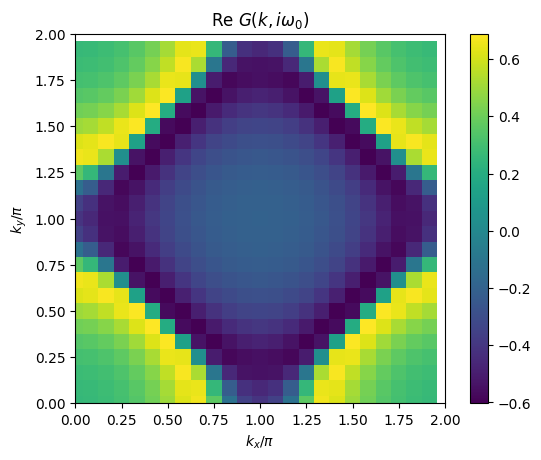

In [7]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. Green function
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.real(solver.gkio[mesh.iw0_f].reshape(mesh.nk1,mesh.nk2)), shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('Re $G(k,i\omega_0)$')
plt.colorbar()
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/78280166.py:4: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$k_x/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/78280166.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$k_y/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/78280166.py:9: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('Re $\chi_0(k,i\nu_0)$')


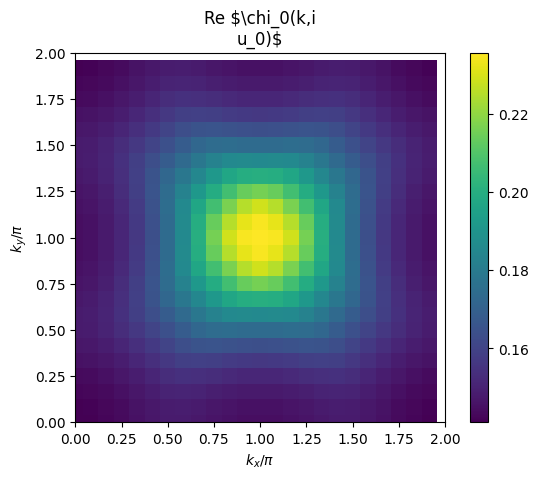

In [8]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.real(solver.ckio[mesh.iw0_b].reshape(mesh.nk1,mesh.nk2)), shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('Re $\chi_0(k,i\nu_0)$')
plt.colorbar()
plt.show()

In [9]:
class LinearizedGapSolver:
    def __init__(self, FLEX_solver, maxiter=50, sfc_tol=1e-4, verbose=True):
        """
        Solver class for solving the linearized gap equation using the power method.
        It takes FLEX results as an input.
        """
        
        ## Initialize necessary quantities from converged (normal state) FLEX calculation
        self.mesh = FLEX_solver.mesh
        self.gkio = FLEX_solver.gkio
        self.chi_spin = FLEX_solver.chi_spin
        self.chi_charge = FLEX_solver.chi_charge
        self.U = FLEX_solver.U
        
        self.maxiter = maxiter
        self.sfc_tol = sfc_tol
        self.verbose = verbose
        
        ## Initialize trial gap function
        # Here we focus on a d-wave symmetric solution
        self.delta0 = (np.cos(2*np.pi*self.mesh.k1) - np.cos(2*np.pi*self.mesh.k2)).reshape(self.mesh.nk)
        self.delta  = np.tensordot(np.ones(len(self.mesh.iwn_f)), self.delta0, axes=0)
        self.delta  = self.delta / np.linalg.norm(self.delta) # normalize initial guess
        
        ## Initialize interaction
        self.V_singlet_calc()
        
        ## Initialize eigenvalue
        self.lam = 0
        
    def solve(self):
        """ Solving instance to find eigenvalue from power method """
        for it in range(self.maxiter):
            lam_old = self.lam
            delta_old = self.delta
    
            # calculate gap function in real space
            self.frit_calc()
            delta = self.V_singlet * self.frit
    
            # Fourier transform to momentum space
            delta = self.mesh.r_to_k(delta)
            delta = self.mesh.tau_to_wn('F',delta)
    
            # calculate eigenvalue
            self.lam = np.real( np.sum(np.conj(delta)*delta_old) )
            self.delta = delta / np.linalg.norm(delta)
    
            # check for convergence
            if self.verbose:
                print(it, self.lam, abs(self.lam-lam_old))
            if abs(self.lam-lam_old) < self.sfc_tol:
                break   
    
    #%%%%%%%%%%% Calculation steps
    def V_singlet_calc(self):
        """ Set up interaction in real space and imaginary time """
    
        V = 3/2*self.U**2 * self.chi_spin - 1/2*self.U**2 * self.chi_charge
        # Constant Hartree Term V ~ U needs to be treated extra, since it cannot be modeled by the IR basis.
        # In the special case of d-wave symmetry, it can be neglected as the momentum sum vanishes due to symmetry.
    
        # Fourier transform
        V = self.mesh.k_to_r(V)
        self.V_singlet = self.mesh.wn_to_tau('B', V)

    def frit_calc(self):
        """ Calculate (linearized) anomalous Green function F = -|G|^2 * delta for evaluating the gap equation """
        self.fkio = - self.gkio*np.conj(self.gkio)*self.delta
        
        # Fourier transform
        frit = self.mesh.k_to_r(self.fkio)
        self.frit = self.mesh.wn_to_tau('F', frit)

In [10]:
gap_solver = LinearizedGapSolver(solver, maxiter=maxiter, sfc_tol=sfc_tol)
gap_solver.solve()
print("The superconducting eigenvalue at T={} is lambda_d={:.3f}".format(T,gap_solver.lam))

0

0.1158743571834693

0.1158743571834693

1

0.40475646217033384

0.2888821049868645

2

0.4482240649718672

0.043467602801533334

3

0.45497739216712973

0.0067533271952625595

4

0.4565802850732953

0.001602892906165554

5

0.4569604787934918

0.0003801937201964867

6

0.457062802084842

0.00010232329135023699

7

0.45708942142418235

2.661933934033911e-05

The superconducting eigenvalue at T=0.1 is lambda_d=0.457

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\o'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/1784683789.py:5: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$k_x/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/1784683789.py:7: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$k_y/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/1784683789.py:16: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$k_x/\pi$')
/var/folders/1t/fxgqx0n17z33

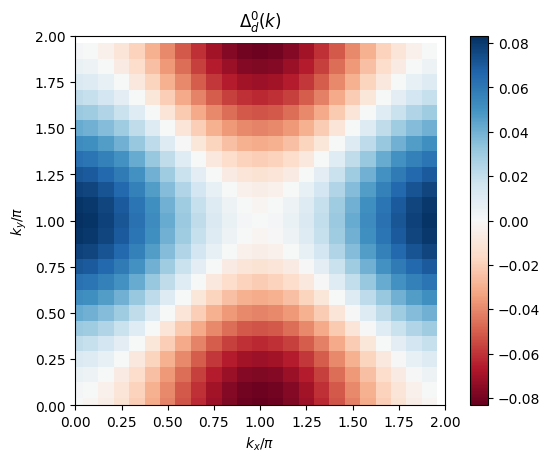

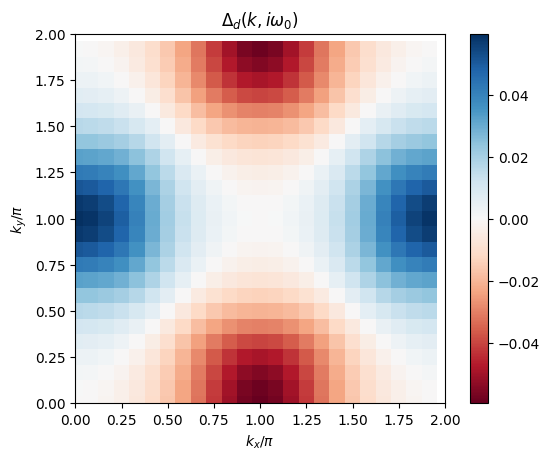

In [11]:
# plot 2D k-dependence of lowest Matsubara frequency of the gap vs. initial guess
plt.figure()
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.real(gap_solver.delta0.reshape(nk1,nk2)) / np.linalg.norm(gap_solver.delta0), cmap='RdBu', shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('$\\Delta^0_d(k)$')
plt.colorbar()

plt.figure()
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.real(gap_solver.delta[mesh.iw0_f].reshape(mesh.nk1,mesh.nk2)), cmap='RdBu', shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('$\\Delta_d(k,i\omega_0)$')
plt.colorbar()
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\o'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/74277736.py:5: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$k_x/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/74277736.py:7: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$k_y/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/74277736.py:10: SyntaxWarning: invalid escape sequence '\o'
  ax.set_title('Re $F(k,i\omega_0)$')


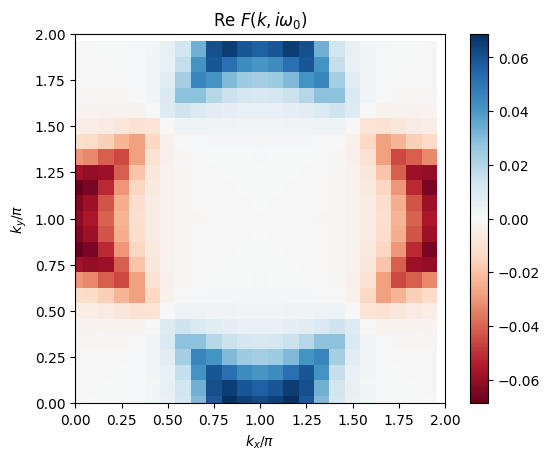

In [12]:
# plot 2D k-dependence of lowest Matsubara frequency of the anomalous Green function
plt.figure()
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.real(gap_solver.fkio[mesh.iw0_f].reshape(mesh.nk1,mesh.nk2)), cmap='RdBu', shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('Re $F(k,i\omega_0)$')
plt.colorbar()
plt.show()

In [13]:
#%%%%%%%%%%%%%%% Parameter settings
print('Initialization...')
# system parameters
t    = 1      # hopping amplitude
n    = 0.85   # electron filling, here per spin per lattice site (n=1: half filling)
U    = 4      # Hubbard interaction

W    = 8*t    # bandwidth
wmax = 10     # set wmax >= W
T_values = np.array([0.08,0.07,0.06,0.05,0.04,0.03,0.025])   # temperature

# numerical parameters
nk1, nk2  = 64, 64    # k-mesh sufficiently dense!
nk        = nk1*nk2
IR_Lambda = 10**3     # dimensionless IR parameter >= w_max * beta_min = 400
IR_tol    = 1e-8      # desired accuary for l-cutoff of IR basis functions
sfc_tol   = 1e-4      # desired accuracy for self-consistent iteration
it_max    = 30        # maximal number of iterations in self-consistent cycle
mix       = 0.2       # mixing parameter for new 
U_it_max  = 50        # maximal number of iteration steps in U renormalization loop

# initialize first IR basis set (no recalculation, just reevaluation afterwards)
beta_init = 1/T_values[0]
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta_init, IR_Lambda/beta_init, eps=IR_tol, use_positive_taus=use_positive_taus)

# set initial self_energy - will be set to previous calculation step afterwards
sigma_init = 0

# empty arrays for results
lam_T     = np.empty((len(T_values)))
chiSmax_T = np.empty((len(T_values)))


#%%%%%%%%%%%%%%% Calculation for different T values
for T_it, T in enumerate(T_values):
    print("Now: T = {}".format(T))
    beta = 1/T

    # initialize meshes
    IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, IR_Lambda/beta, eps=IR_tol, sve_result=IR_basis_set.sve_result, use_positive_taus=use_positive_taus)
    mesh = Mesh(IR_basis_set, nk1, nk2)
    
    # calculate FLEX loop
    solver = FLEXSolver(mesh, U, n, sigma_init=sigma_init, sfc_tol=sfc_tol, 
                        maxiter=maxiter, U_maxiter=U_maxiter, mix=mix, verbose=False)
    solver.solve()
    sigma_init = solver.sigma

    # calculate linearized gap equation
    gap_solver = LinearizedGapSolver(solver, maxiter=maxiter, sfc_tol=sfc_tol, verbose=False)
    gap_solver.solve()
    
    # save data for plotting
    lam_T[T_it] = gap_solver.lam#
    chiSmax_T[T_it] = np.real(np.amax(solver.chi_spin))
    
    if T == 0.03:
        chi_s_plt = np.real(solver.chi_spin)[mesh.iw0_b].reshape(mesh.nk1,mesh.nk2)

Initialization...

Now: T = 0.08

Initiate U renormalization loop.

1

2.2871467317646927

4

2

2.4856847003532696

4

3

2.6890779964751355

4

4

2.8952475069849086

4

5

3.100419431365168

4

6

3.306837872695085

4

7

3.5156369042984172

4

8

3.7272843226414016

4

9

3.941717268449172

4

Leaving U renormalization...

FLEX loop converged at desired accuracy

FLEX loop finished

 mu = 

-0.6743334885883465

n = 

0.8499999999999994

Now: T = 0.07

FLEX loop converged at desired accuracy

FLEX loop finished

 mu = 

-0.6758310002446527

n = 

0.8499999999999996

Now: T = 0.06

FLEX loop converged at desired accuracy

FLEX loop finished

 mu = 

-0.6773211297218565

n = 

0.8500000000000003

Now: T = 0.05

FLEX loop converged at desired accuracy

FLEX loop finished

 mu = 

-0.678603389127441

n = 

0.849999999999999

Now: T = 0.04

FLEX loop converged at desired accuracy

FLEX loop finished

 mu = 

-0.6795225324836868

n = 

0.849999999999999

Now: T = 0.03

FLEX loop converged at desired accuracy

FLEX loop finished

 mu = 

-0.6799832830244742

n = 

0.8499999999999994

Now: T = 0.025

FLEX loop converged at desired accuracy

FLEX loop finished

 mu = 

-0.6801766287520092

n = 

0.8500000000000003

<>:20: SyntaxWarning: invalid escape sequence '\G'
<>:20: SyntaxWarning: invalid escape sequence '\G'
<>:27: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\l'
<>:20: SyntaxWarning: invalid escape sequence '\G'
<>:20: SyntaxWarning: invalid escape sequence '\G'
<>:27: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\l'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/2352191630.py:20: SyntaxWarning: invalid escape sequence '\G'
  f_ax1.set_xticklabels(['$\Gamma$','X','M','$\Gamma$'])
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/2352191630.py:20: SyntaxWarning: invalid escape sequence '\G'
  f_ax1.set_xticklabels(['$\Gamma$','X','M','$\Gamma$'])
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57458/2352191630.py:27: SyntaxWarning: invalid escape sequence 

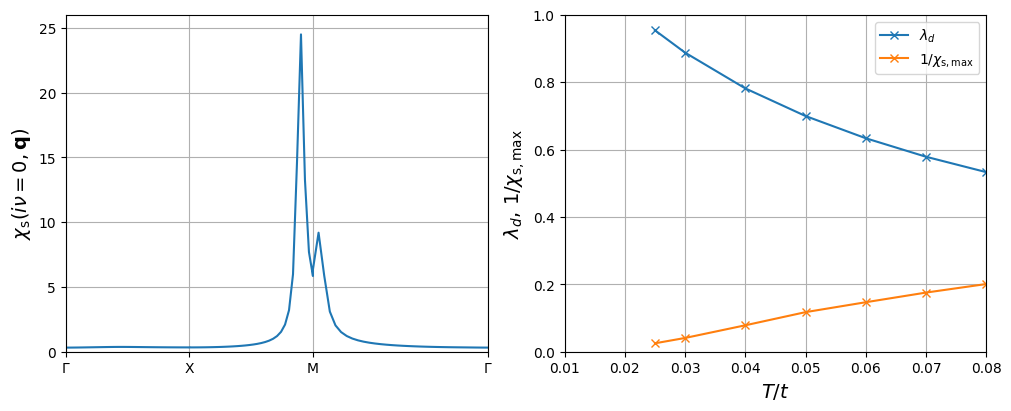

In [14]:
#%%%%%%%%%%%%%%%% Plot results in a combined figure
import matplotlib.gridspec as gridspec

fig   = plt.figure(figsize=(10,4),constrained_layout=True)
spec  = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])

# first panel with momentum dependence of static spin susceptibility
k_HSP = np.concatenate((np.linspace(0,1,mesh.nk1//2),
                        np.linspace(1,2,mesh.nk2//2),
                        np.linspace(2,2+np.sqrt(2),mesh.nk1//2)))
chi_s_HSP = np.concatenate((chi_s_plt[:mesh.nk1//2, 0],
                          chi_s_plt[mesh.nk1//2, :mesh.nk2//2],
                          [chi_s_plt[it,it] for it in range(mesh.nk1//2)][::-1]))

f_ax1.plot(k_HSP, chi_s_HSP,'-')
f_ax1.set_xlim([0,2+np.sqrt(2)])
f_ax1.set_xticks([0,1,2,2+np.sqrt(2)])
f_ax1.set_xticklabels(['$\Gamma$','X','M','$\Gamma$'])
f_ax1.set_ylim([0,26])
f_ax1.set_xlabel('')
f_ax1.set_ylabel('$\\chi_{\\mathrm{s}}(i\\nu=0,{\\bf{q}})$', fontsize=14)
f_ax1.grid()

# second panel with T-dependence of lambda_d and 1/chi_s,max
f_ax2.plot(T_values, lam_T, '-x', label='$\lambda_d$')
f_ax2.plot(T_values, 1/chiSmax_T, '-x', label='$1/\chi_{\mathrm{s},\mathrm{max}}$')
f_ax2.set_xlim([0.01,0.08])
f_ax2.set_ylim([0,1])
f_ax2.set_xlabel('$T/t$', fontsize=14)
f_ax2.set_ylabel('$\lambda_d$, $1/\chi_{\mathrm{s},\mathrm{max}}$', fontsize=14)
f_ax2.legend()
f_ax2.grid()
plt.show()